# Project 3
**Group 2** 
Ada Matilde Gige (adgi@itu.dk), Albert Schiffer (albsc@itu.dk), Andreas Frederik Flensted Olsen (frao@itu.dk), Timothy Beck (tibe@itu.dk) and Victor Popp Henriksen (vhen@itu.dk)

Created: 2021-04-06

Last modified: 2021-04-22

Link to repo: https://github.com/adagige/fyp2021p03g02.git

# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns

from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage import transform
from PIL import Image 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import classification_report

import glob #For finding specific file types

%run -i ../fyp2021p3_group00_functions.py

# Running or watching code?

### If you are interested in only watching the code set the constant run to False, if you want to run the code set the constant to True

When watching the code some files will be loaded, but it is feature files which are already made by the code in the Notebook and then saved

In [21]:
run = False

# Loading raw datafiles

In [3]:

#load all images of type .jpg
im_file_list2 = glob.glob("../data/example_image/*.jpg")
#load all maps of type .png
map_file_list2 = glob.glob("../data/example_segmentation/*.png")

#load external images 
im_file_liste = glob.glob("../data/external_data/resized_images/*.jpg")
#Load external maps
map_file_liste = glob.glob("../data/external_data/resized_masks/*.png")

#im_files = sorted(im_file_list2, key = uniq)
im_files = sorted(im_file_list2)
len(im_files)

#map_files = sorted(map_file_list2, key = uniq)
map_files = sorted(map_file_list2)
len(map_files)

#im_files = sorted(im_file_list2, key = uniq)
im_filese = sorted(im_file_liste)
len(im_filese)

#map_files = sorted(map_file_list2, key = uniq)
map_filese = sorted(map_file_liste)
len(map_filese)    



# Loading the true file in
true1 = pd.read_csv('../data/example_ground_truth.csv')
true2 = pd.read_csv('../data/external_data/resized_ISIC-2017_Training_Part3_GroundTruth.csv')

true = pd.concat([true1, true2], ignore_index=True)
# It is already sorted why it is not sorted as the others


## Loading the images into a list and making an ID dictionary
Taken from: https://stackoverflow.com/questions/33369832/read-multiple-images-on-a-folder-in-opencv-python/33371454

In [4]:
images = []
for file in im_files:
    im = Image.open(file)
    im = im.resize((800,500), resample=1) 
    images.append(im)

for file in im_filese:
    im = Image.open(file)
    images.append(im)

maps = []

for file in map_files:
    ma = Image.open(file)
    ma = ma.resize((800,500), resample=1)
    maps.append(ma)

for file in map_filese:
    ma = Image.open(file)
    maps.append(ma)


# Making a dictionary to find the id from the index
pic_id = dict()

for i in range(150):
    pic_id[i] = true['image_id'][i]

# Features

## Assymetry
The assymetry is meassured by finding the center of the image, measuring the distance to the border on each side and comparing the two, the difference was squared to prevent negative number and added to the onstant difference. Then the image was rotated 5 degrees and the mesurement was done once again, the image was rotated 36 times. Adter the rotation the difference was divided by the area of the lesion to normalise the meassurement. 

In [12]:
#A function that finds the center of a picture and meassures the assymmetri

def assymmetry(mapID):
    mask = np.array(maps[mapID])
    
    borders = np.where(mask == 1) # This will return 2 arrays with the index where the pixels are ones
    up, down, left, right = max(borders[0]), min(borders[0]), min(borders[1]), max(borders[1])
    center = ((left + right)//2, (up+down) //2) # Tuple with the coordinates for the center of the lesion
    
    difference = 0
    
    for i in range(36):
        borders = np.where(mask == 1) # This will return 2 arrays with the index where the pixels are ones
        left, right = min(borders[1]), max(borders[1])
        
        radiusdiff = (center[0]-left) - (right-center[0])
        difference += radiusdiff**2
        mask = transform.rotate(mask, 5, center = center)
    return difference/areas[mapID]
    

We ran all images through the function via the lines of code below and saved the output to a file to save time.

In [ ]:
# Making a list with all asymmetry values in it and then savin it.
if run:
    asymmetrylist = []

    for i in range(300):
        asymmetrylist.append(assymmetry(i))

    #np.savetxt("../data/features/assymmetry36.csv", asymmetrylist, delimiter=",")

### Showing how the assymettry function works

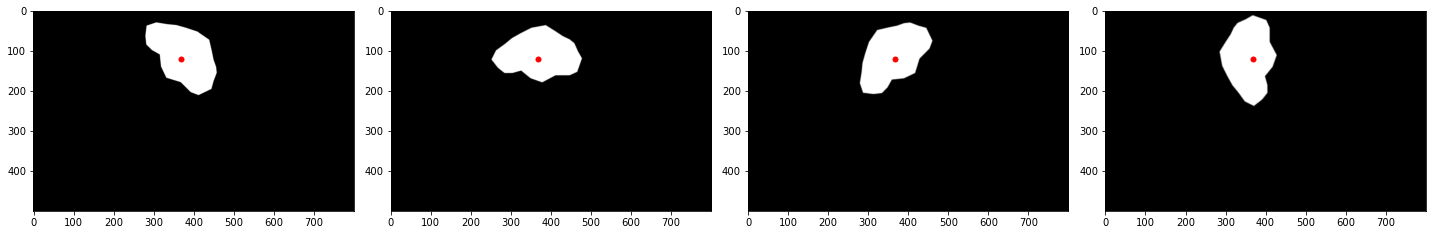

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))

mask = np.array(maps[4])

borders = np.where(mask == 1) # This will return 2 arrays with the index where the pixels are ones
up, down, left, right = max(borders[0]), min(borders[0]), min(borders[1]), max(borders[1])
center = ((left + right)//2, (up+down) //2) # Tuple with the coordinates for the center of the lesion

difference = 0

for i in range(4):
    borders = np.where(mask == 1) # This will return 2 arrays with the index where the pixels are ones
    left, right = min(borders[1]), max(borders[1])
   
    
    axes[i].imshow(mask, cmap = 'gray')
    axes[i].scatter(center[0], center[1], s=25, c='red', marker='o')
   # axes[i].show()
    
    radiusdiff = (center[0]-left) - (right-center[0])
    difference += radiusdiff**2
    mask = transform.rotate(mask, 45, center = center)

fig.tight_layout()

## Border

To measure the regularity of the border the ration perimeter divided by area was used. The area and perimeter ratio has shown great results in other studies, Fikrle and Pizinger 2007. 
https://groups.inf.ed.ac.uk/vision/MCDONAGH/related%20work/literature/digital%20computer%20analysis%20of%20dermatoscopical%20images%20-%20Fikrle%20Pizinger%20-%20March%202006.pdf

### Area and perimeter
To find the area and perimeter we 

In [ ]:
if run: 
    #Loading the maps in as plt files to be used to find the area an perimiter.

    #load all maps of type .png
    map_file_area = glob.glob("../data/example_segmentation_resize/*.png")

    #Load external maps
    map_filee_area = glob.glob("../data/external_data/resized_masks/*.png")


    map_files_area = sorted(map_file_area)

    map_filese_area = sorted(map_filee_area)   


    mapsarea = []

    for file in map_files_area:
        im = plt.imread(file)
        mapsarea.append(im)

    for file in map_filese_area:
        im = plt.imread(file)
        mapsarea.append(im)


In [ ]:
if run: 
    # Finding the area and perimeter of all images. 
'''With the use of morphology.disk(10)'''


areas = []
peris = []
for i in mapsarea:
    area, perimiter = measure_area_perimeter(i)
    areas.append(area)
    peris.append(perimiter)
    
# Adding them to a file, so they don't have to be calculated each time

#np.savetxt("../data/features/perimeter10.csv", peris, delimiter=",")
#np.savetxt("../data/features/area10.csv", areas, delimiter=",")